<a href="https://colab.research.google.com/github/willyptrain/cs4774-mask-detection/blob/main/cs_4774_mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
from google.colab import drive
drive.mount("/content/drive/")

!unzip 'drive/My Drive/face_mask_detection.zip'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Archive:  drive/My Drive/face_mask_detection.zip
replace annotations/maksssksksss0.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [43]:
import torchvision
import glob
import os
from bs4 import BeautifulSoup
import numpy as np


In [44]:


def load_train_split_paths(directory):
  img_paths = glob.iglob(directory)
  path_bases = []
  for path in img_paths:
    path_bases.append(path.split("/")[1].rstrip(".png"))

  path_bases = sorted(path_bases)

  train_paths = path_bases[0:500]
  val_paths = path_bases[500:700]
  test_paths = path_bases[700:]

  print("Training size:", len(train_paths))
  print("Validation size:", len(val_paths))
  print("Testing size:", len(test_paths))
  return train_paths, val_paths, test_paths

train_paths, val_paths, test_paths = load_train_split_paths("images/*")

Training size: 500
Validation size: 200
Testing size: 153


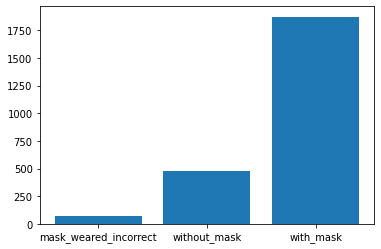

In [95]:
def read_annotations(base_dir, paths):
  label_mappings = {"with_mask": 0, "mask_weared_incorrect": 1, "without_mask":2}
  annotation_set = {}
  y = []
  y_labels = []
  y_boxes = []
  literal_labels = []
  for path in paths:
    xml_path = os.path.join(base_dir, path) + ".xml"
    with open(xml_path) as f:
      contents = f.read()
    xml_read = BeautifulSoup(contents, "xml")
    
    classes = []
    boxes = []

    truth_detections = xml_read.find_all("object")
    for obj in truth_detections:
      xmin = int(obj.find('xmin').text)
      xmax = int(obj.find('xmax').text)
      ymin = int(obj.find('ymin').text)
      ymax = int(obj.find('ymax').text)
      boxes.append([xmin, xmax, ymin, ymax])
      if(obj.find('name').text in label_mappings):
        classes.append(label_mappings[obj.find('name').text])
        literal_labels.append(obj.find('name').text)
      else: 
        literal_labels.append("N/A")
        classes.append(-1)

    classes = np.array(classes)
    boxes = np.array(boxes)
    y_boxes.append(boxes)
    y_labels.append(classes)
  

    annotation_set[path] = [classes, boxes]

    y.append([classes, boxes])
  return annotation_set, y_boxes, y_labels, literal_labels


train_annotation_set, y_train_boxes, y_train_labels, train_literal_labels = read_annotations('annotations/', train_paths)
val_annotation_set, y_val_boxes, y_val_labels, val_literal_labels = read_annotations('annotations/', val_paths)

import matplotlib.pyplot as plt
from collections import Counter


frequency_unique_labels = Counter(train_literal_labels)
frequency_unique_labels = sorted(frequency_unique_labels.items(), key=lambda x: x[1])
plt.bar([i[0] for i in frequency_unique_labels], [i[1] for i in frequency_unique_labels])
plt.show()

In [59]:
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset


class FaceMaskDataset(Dataset):
  def __init__(self, labels, boxes, transform=None):
    self.base_dir = 'images/'
    self.labels = labels #actual labels/classes from read_annotations()
    self.boxes = boxes #actual boxes from read_annotations()
    self.transform = transform #in case data needs to be transformed to torch tensor before fed into model


  def __getitem__(self, idx):
    if(torch.is_tensor(idx)):
      idx = idx.tolist()

    image_path = os.listdir(self.base_dir, 'maksssksksss', idx, ".png")
    print(image_path)

  def __len__(self):
    return len(self.labels)


mask_dataset = FaceMaskDataset(labels=y_train_labels, boxes=y_train_boxes)
print(mask_dataset)


In [48]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)



Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
